Micrograd Clone

In [416]:
import math
import numpy as np
import matplotlib.pyplot as plt


In [417]:
def f(x):
    return 3*x**2 - 4*x + 5

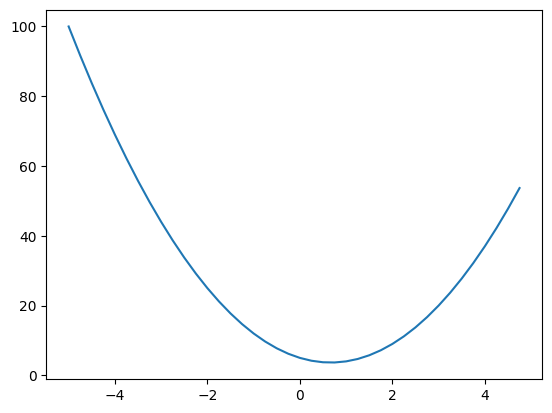

In [418]:
xs = np.arange(-5, 5, 0.25)

ys = f(xs)

plt.plot(xs, ys)

In [419]:
h = 0.0000001
x = 3.0
(f(x + h) - f(x)) / h

14.000000305713911

In [420]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label


    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other) 

        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward
        return out    
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other) 

        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward
        return out
    
    def __rmul__(self, other):
        return self * other
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only support int/float power"
        out = Value(self.data**other, (self, ), f'**{other}')

        def _backward():    
            self.grad += other * (self.data**(other-1)) * out.grad
            
        out._backward = _backward
        return out
    
    def __truediv__(self, other):
        return self * other**-1

    def tanh(self):
        n = self.data
        t = (math.exp(2*n) - 1)/(math.exp(2*n) + 1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad

        out._backward = _backward
        return out
    
    def exp(self):
        x = self.data
    
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0

        for node in reversed(topo):
            node._backward()

    
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
print(a + b)
print(a*b)
e = a*b; e.label='e'
d = e + c; d.label='d'
f = Value(-2.0, label='f')
L = d * f; L.label='L'

Value(data=-1.0)
Value(data=-6.0)


In [421]:
print(d._prev)

{Value(data=10.0), Value(data=-6.0)}


In [422]:
print(d._op)

+


In [423]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label = "{%s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name = uid+n._op, label = n._op)
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2))+ n2._op)

    return dot

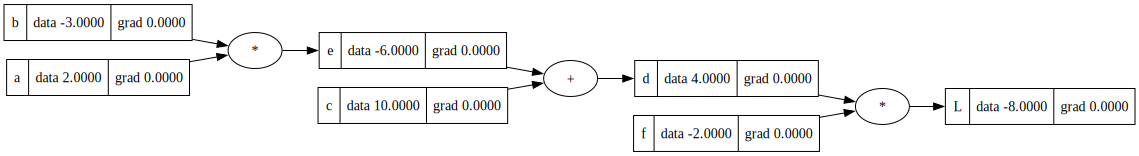

In [424]:
draw_dot(L)

In [425]:
L.grad = 1.0

#dL/dd = (f(x+h) - f(x))/h = (((d+h)*f) - d*f)/h = (d*f + f*h - d*f)/h = f
#dL/df = (f(x+h) - f(x))/h = ((d*(f+h)) - d*f)/h = (d*f + d*h - d*f)/h = d
d.grad = f.data
f.grad = d.data

#-- Chain rule --
#dL/de = dL/dd * dd/de
#dL/dc = dL/dd * dd/dc 
#dd/de = (f(x+h) - f(x))/h = (((c+h)+e) - c+e)/h = (c + h + e - c - e)/h = 1.0
e.grad = d.grad * 1.0
c.grad = d.grad * 1.0

#-- Chain rule --
#dL/da = dL/de * de/da
#dL/db = dL/de * de/db
a.grad = e.grad * b.data
b.grad = e.grad * a.data 



In [426]:
def lol():
    h = 0.0001
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    print(a + b)
    print(a*b)
    e = a*b; e.label='e'
    d = e + c; d.label='d'
    f = Value(-2.0, label='f')
    L = d * f; L.label='L'
    L1 = L.data

    a = Value(2.0, label='a')
    b = Value(-3.0+h, label='b')
    c = Value(10.0 , label='c')
    print(a + b)
    print(a*b)
    e = a*b; e.label='e'
    d = e + c; d.label='d'
    f = Value(-2.0, label='f')
    L = d * f; L.label='L'
    L2 = L.data

    print((L2 - L1)/h)

lol()

Value(data=-1.0)
Value(data=-6.0)
Value(data=-0.9998999999999998)
Value(data=-5.9998)
-4.000000000008441


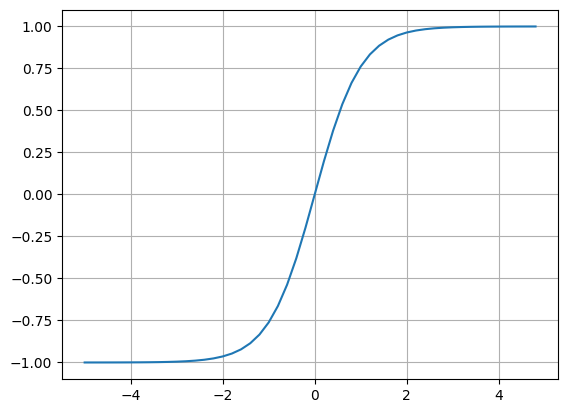

In [427]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2)))
plt.grid()

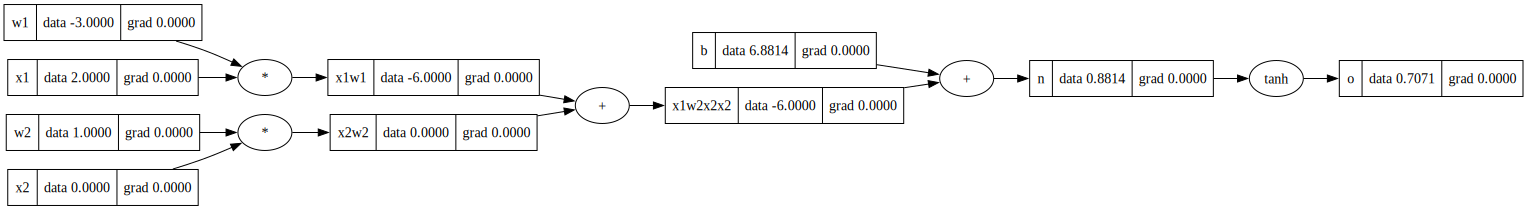

In [428]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label='x1w1'
x2w2 = x2*w2; x2w2.label='x2w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w2x2x2'

n = x1w1x2w2 + b; n.label='n'

o = n.tanh(); o.label='o'

draw_dot(o)


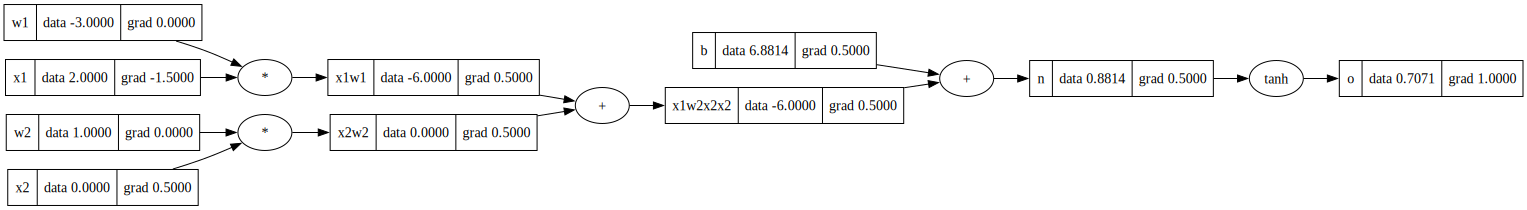

In [429]:
#manual
o.grad = 1.0

# do/dn = 1 - o**2
n.grad = 1 - o.data**2 

x1w1x2w2.grad = n.grad
b.grad = n.grad

x1w1.grad = x1w1x2w2.grad
x2w2.grad = x1w1x2w2.grad

x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

x2.grad = w2.data * x2w2.grad
w1.grad = x2.data * x2w2.grad

draw_dot(o)

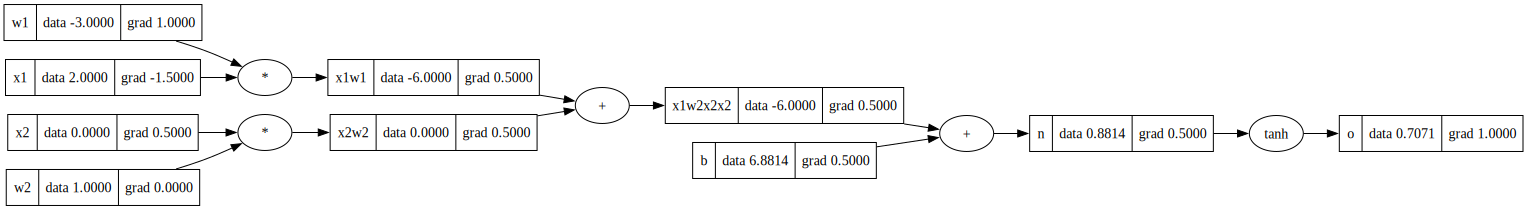

In [430]:
#autoamtic
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label='x1w1'
x2w2 = x2*w2; x2w2.label='x2w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w2x2x2'

n = x1w1x2w2 + b; n.label='n'

o = n.tanh(); o.label='o'

o.grad = 1.0
o._backward()
n._backward()
b._backward()
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()

draw_dot(o)

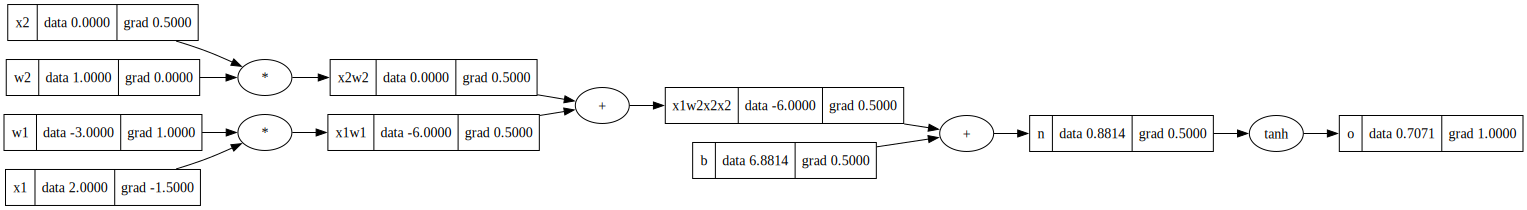

In [431]:
#fully automatic
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label='x1w1'
x2w2 = x2*w2; x2w2.label='x2w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w2x2x2'

n = x1w1x2w2 + b; n.label='n'

o = n.tanh(); o.label='o'

o.backward()

draw_dot(o)

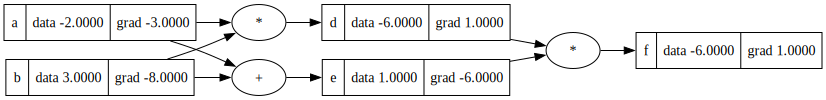

In [432]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')

d = a * b; d.label='d'
e = a + b; e.label='e'
f = d * e; f.label='f'

f.backward()

draw_dot(f)


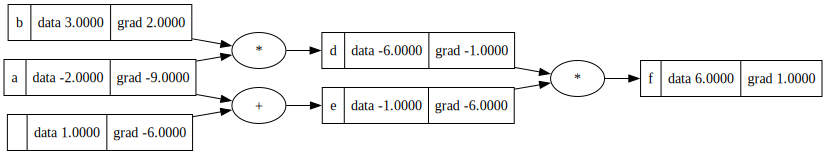

In [433]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')

d = a * b; d.label='d'
e = a + 1; e.label='e'
f = d * e; f.label='f'

f.backward()

draw_dot(f)


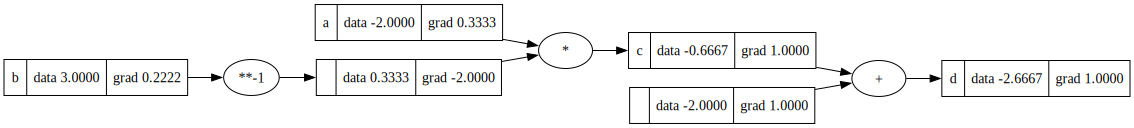

In [434]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')

c = a/b; c.label='c'

d = c - 2.0; d.label='d'

d.backward()

draw_dot(d)


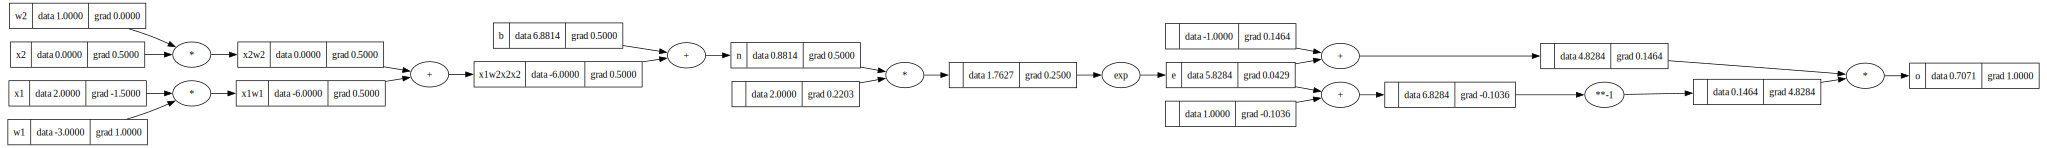

In [435]:
#fully automatic, brokedown tanh
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label='x1w1'
x2w2 = x2*w2; x2w2.label='x2w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w2x2x2'

n = x1w1x2w2 + b; n.label='n'

e = (2*n).exp(); e.label='e'

o = (e - 1) / (e + 1); o.label='o'

o.backward()

draw_dot(o)

In [436]:
#%pip install torch

In [437]:
import torch

x1 = torch.Tensor([2.0]).double()
x1.requires_grad = True

x2 = torch.Tensor([0.0]).double()
x2.requires_grad = True

w1 = torch.Tensor([-3.0]).double()
w1.requires_grad = True

w2 = torch.Tensor([1.0]).double()
w2.requires_grad = True

b = torch.Tensor([6.8813735870195432])
b.requires_grad = True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('----')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
----
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [438]:
import random

class Neuron:

    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        act = sum((wi*xi for wi, xi in zip(self.w, x)) ,self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]

class Layer:

    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        params = []
        for neuron in self.neurons:
            ps = neuron.parameters()
            params.extend(ps)
        return params

class MLP:

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()] 



In [439]:
print("---single neuron---")
x = [2.0, 3.0]
n = Neuron(2)
print(n(x))

print("---single layer---")
l = Layer(2, 3)
print(l(x))

print("---mlp---")
x = [2.0, 3.0, -1.0]
mlp = MLP(3, [4, 4, 1])
print(mlp(x))


---single neuron---
Value(data=0.12809030551390024)
---single layer---
[Value(data=-0.9805664898596524), Value(data=-0.997063078133434), Value(data=0.40034632975936396)]
---mlp---
Value(data=-0.02622549553422521)


In [440]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]
ypred = [mlp(x) for x in xs]
print(f'Y predictions: {ypred}')

loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)], Value(0.0)); loss.label='loss'
print(f"Loss: {loss}")

print(mlp.parameters())



Y predictions: [Value(data=-0.02622549553422521), Value(data=-0.7750443433154193), Value(data=-0.6092738407009957), Value(data=-0.9218172853899648)]
Loss: Value(data=4.949792425143062)
[Value(data=-0.46905118219201447), Value(data=-0.5091547963997254), Value(data=0.38977843905849774), Value(data=0.41122136559579614), Value(data=0.512090602304583), Value(data=0.7603447423647114), Value(data=0.06916958012727337), Value(data=-0.9751352469159602), Value(data=0.4804614919358092), Value(data=-0.9381398891887616), Value(data=0.6422951285380938), Value(data=-0.6889663953436693), Value(data=0.2366489494850843), Value(data=0.5527414437938654), Value(data=0.3376007446902054), Value(data=-0.8388020922713757), Value(data=-0.2600069989899654), Value(data=0.08665577664343149), Value(data=0.2491086612138409), Value(data=0.7187633438005063), Value(data=0.9891452998835732), Value(data=-0.7506261972849502), Value(data=-0.7932407665006875), Value(data=-0.5496358713736627), Value(data=-0.9956567721019216),

In [441]:
print(mlp.parameters())
ypred

[Value(data=-0.46905118219201447), Value(data=-0.5091547963997254), Value(data=0.38977843905849774), Value(data=0.41122136559579614), Value(data=0.512090602304583), Value(data=0.7603447423647114), Value(data=0.06916958012727337), Value(data=-0.9751352469159602), Value(data=0.4804614919358092), Value(data=-0.9381398891887616), Value(data=0.6422951285380938), Value(data=-0.6889663953436693), Value(data=0.2366489494850843), Value(data=0.5527414437938654), Value(data=0.3376007446902054), Value(data=-0.8388020922713757), Value(data=-0.2600069989899654), Value(data=0.08665577664343149), Value(data=0.2491086612138409), Value(data=0.7187633438005063), Value(data=0.9891452998835732), Value(data=-0.7506261972849502), Value(data=-0.7932407665006875), Value(data=-0.5496358713736627), Value(data=-0.9956567721019216), Value(data=-0.22054246942803002), Value(data=0.24779585668974802), Value(data=0.7864314390577434), Value(data=0.10638956816144551), Value(data=0.34318498849109047), Value(data=-0.89434

[Value(data=-0.02622549553422521),
 Value(data=-0.7750443433154193),
 Value(data=-0.6092738407009957),
 Value(data=-0.9218172853899648)]

In [442]:
for k in range(20):
    #forward pass
    ypred = [mlp(x) for x in xs]
    loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)], Value(0.0)); loss.label='loss'

    #zero_grad
    for p in mlp.parameters():
        p.grad = 0.0

    #backward pass
    loss.backward()

    for p in mlp.parameters():
        p.data += - 0.05 * p.grad

    print(k, loss.data)





0 4.949792425143062
1 3.664598290103436
2 2.2992798251776096
3 1.0353897732787871
4 0.4941989518214659
5 0.1179146816190133
6 0.09621242632266055
7 0.08208819227390093
8 0.07168026282423329
9 0.06360833194716911
10 0.05714850586032909
11 0.051858769369583654
12 0.047447822740836074
13 0.043714304880656
14 0.04051412728292947
15 0.03774133617457477
16 0.035316245535214244
17 0.03317776638883127
18 0.031278283381103826
19 0.029580138735233807


In [443]:
print(mlp.parameters())
ypred

[Value(data=-0.5203370667284583), Value(data=-0.5188821632503327), Value(data=0.23538293217672662), Value(data=0.3549537802045635), Value(data=0.5117648259792517), Value(data=0.8584784855055144), Value(data=-0.5888636192152283), Value(data=-1.0107098008856468), Value(data=0.46611306323316987), Value(data=-0.9644878730869425), Value(data=0.5979060159053374), Value(data=-0.7188240331953144), Value(data=0.3349246559784455), Value(data=0.791413231425582), Value(data=-0.35936994422467844), Value(data=-0.8130333757224305), Value(data=-0.2935790631828797), Value(data=0.1257762513982568), Value(data=0.2178292066647121), Value(data=0.7292095116414441), Value(data=0.9758709648852973), Value(data=-0.5588517742953052), Value(data=-0.9809741158737053), Value(data=-0.3569753595029546), Value(data=-1.0790828935737973), Value(data=-0.26610313644833244), Value(data=-0.041412526248661576), Value(data=1.0419252823020948), Value(data=-0.175421568322784), Value(data=0.4788599352998266), Value(data=-0.68947

[Value(data=0.9581944421364298),
 Value(data=-0.9438954959657919),
 Value(data=-0.8896834097332637),
 Value(data=0.8881296795126338)]